In [1]:
import json

In [2]:
json_args_dict = {
    "model_args": {
        "bert_model_name": 'michiyasunaga/BioLinkBERT-base',
        "bert_tokenizer_name" :'michiyasunaga/BioLinkBERT-base',
        "freeze_base_weights": False,
        "id2label": {"0": "irrelevant", "1": "relevant"},
        "num_labels": 2,
    },
    "data_args": {
        "dataframe_path": "datasets/split_with_translations.csv",
        "text_column_name": "title_extraction",
        "labels_column_name": "class",
        "shuffle": True,
        "downsample": False,

    },
    "tokenizer_args": {
        "max_length" : 30,
        "padding" : 'max_length',
        "truncation" : True,
    },
    "preprocessing_args": {
        "train_size": 0.8,
        "dev_size": 0.1,
        "test_size": 0.1,
    },
    "finetuning_args": {
        ## arguments for a HuggingFace TrainingArguments object.
        "output_dir": "multilingual_bert_finetuning_05",
        "num_train_epochs": 2,
        "overwrite_output_dir": True,
        "evaluation_strategy": "steps",
        "eval_steps": 50,
        "save_strategy": "steps",
        "save_steps" : 100,
        "learning_rate": 1e-6,  # 1e-6
        
        "per_device_train_batch_size": 16,
        "per_device_eval_batch_size": 16,

        # weight_decay=0.01,
        "load_best_model_at_end": True,
        "logging_strategy": 'steps',
        "logging_steps": 50,
        "disable_tqdm": False,
        # metric_for_best_model="f1", #defaults to 'loss'
        # push_to_hub=True,
        "optim" :"adamw_torch",

    }

}


In [3]:
from text_classification_bibliome import bert_finetuning

In [4]:
%%time
finetuning_results_dict = bert_finetuning.bibliome_finetune_on_dataset(
    json_args_dict
)

Loading dataset
Loaded dataset with 8295 entries.
Dropping 222 NaN values from dataset, that is, 2.68% of the dataset
New dataset size: 8073
Loading tokenizer
Preprocessing dataset


Map:   0%|          | 0/6458 [00:00<?, ? examples/s]

Map:   0%|          | 0/807 [00:00<?, ? examples/s]

Map:   0%|          | 0/808 [00:00<?, ? examples/s]

Loading bert model


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at michiyasunaga/BioLinkBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Started fine-tuning...


Step,Training Loss,Validation Loss


Finished fine-tuning
CPU times: user 1min 33s, sys: 8.28 s, total: 1min 41s
Wall time: 1min 43s


In [5]:
checkpoint_dir = finetuning_results_dict["best_model_checkpoint_dir"]
print(checkpoint_dir)

multilingual_bert_finetuning_05/checkpoint-300


In [6]:
pipeline = bert_finetuning.bibliome_load_pipeline_from_pretrained(
    checkpoint_dir = checkpoint_dir,
    all_args_dict_or_path=json_args_dict
)

In [7]:
pipeline(
    "This is a dummy text"
)

[[{'label': 'irrelevant', 'score': 0.6164414286613464},
  {'label': 'relevant', 'score': 0.3835585117340088}]]

In [8]:
pipeline(
    ["This is a dummy text",
     "As plantas são importantes"
     ]
)

[[{'label': 'irrelevant', 'score': 0.6164414286613464},
  {'label': 'relevant', 'score': 0.3835585117340088}],
 [{'label': 'irrelevant', 'score': 0.6200186610221863},
  {'label': 'relevant', 'score': 0.3799813985824585}]]

# Check performance on test split

In [9]:
# performance on test split

test_split = finetuning_results_dict["tokenized_encoded_dataset"]["test"]
len(test_split)


808

In [10]:
pipeline = bert_finetuning.bibliome_load_pipeline_from_pretrained(
    checkpoint_dir = checkpoint_dir,
    all_args_dict_or_path=json_args_dict
)

In [11]:
# test some strings
pipeline([
    "This is a dummy text",
    "As plantas são importantes"
])


[[{'label': 'irrelevant', 'score': 0.6164414286613464},
  {'label': 'relevant', 'score': 0.3835585117340088}],
 [{'label': 'irrelevant', 'score': 0.6200186610221863},
  {'label': 'relevant', 'score': 0.3799813985824585}]]

In [12]:
pipeline("hello world")

[[{'label': 'irrelevant', 'score': 0.6644464135169983},
  {'label': 'relevant', 'score': 0.3355535864830017}]]

In [13]:
# make predicitons on the test split
from tqdm import tqdm
predictions_on_test_split = []
for text in tqdm(test_split['text']):
    pred = pipeline(text)[0]
    predictions_on_test_split.append(pred)


100%|██████████| 808/808 [00:33<00:00, 24.24it/s]


In [14]:
predictions_on_test_split[0]

[{'label': 'irrelevant', 'score': 0.5392255187034607},
 {'label': 'relevant', 'score': 0.4607745409011841}]

In [15]:
pipeline.model.config.id2label

{0: 'irrelevant', 1: 'relevant'}

In [16]:
pipeline.model.config.label2id

{'irrelevant': '0', 'relevant': '1'}

In [17]:
# put the true labels and predictions on a dataframe.
import pandas as pd

results_df = {
    # labels must be converted from tensor to list of ints
    "labels": [int(id) for id in list(test_split["labels"])],

    # predictions must be converted from list of label names
    # to list of label ids
    "predictions": [
        int(
            pipeline.model.config.label2id[item[0]['label']]
        )
        for item in predictions_on_test_split]
}
results_df = pd.DataFrame(results_df)
results_df


,labels,predictions
0,0,0
1,0,0
2,0,1
3,0,0
4,0,0
...,...,...
803,0,0
804,0,0
805,1,1
806,0,1


## Calculating accuracy, precission, recall, and f1

In [18]:
# evaluate performance with precision, recall, and f1
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

In [19]:
precision_recall_fscore_support(
    y_true=results_df['labels'],
    y_pred=results_df['predictions'],
    average='binary'
)


(0.16201117318435754, 0.6590909090909091, 0.2600896860986547, None)

In [20]:
accuracy_score(
    y_true=results_df['labels'],
    y_pred=results_df['predictions'],
)


0.5915841584158416

# Plots

In [21]:
import matplotlib.pyplot as plt
import json
import os

In [22]:
last_model_checkpoint_dir = finetuning_results_dict["last_model_checkpoint_dir"]
last_model_checkpoint_dir

'multilingual_bert_finetuning_05/checkpoint-800'

In [23]:
with open(os.path.join(last_model_checkpoint_dir, "trainer_state.json"), 'r') as f:
    trainer_state = json.load(f)

In [24]:
def get_metric_evolution(trainer_state, metric_name):
    
    metric_evolution =  [
        ( entry['step'], entry[metric_name] )  
        for entry in trainer_state['log_history'] 
        if (entry.get(metric_name) or entry.get(metric_name) == 0.0)

    ] 

    return metric_evolution

In [25]:
def plot_metric_evolution(trainer_state, metric_name):
    metric_evolution = get_metric_evolution(trainer_state, metric_name)
    plt.scatter(*zip(*metric_evolution))
    plt.title(f'Training evolution of {metric_name}')
    plt.xlabel('Steps')
    plt.ylabel(f'{metric_name}')
    plt.show()


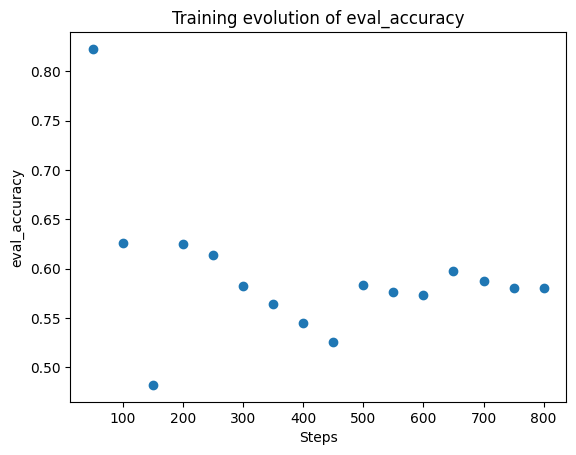

In [26]:
plot_metric_evolution(trainer_state, "eval_accuracy")

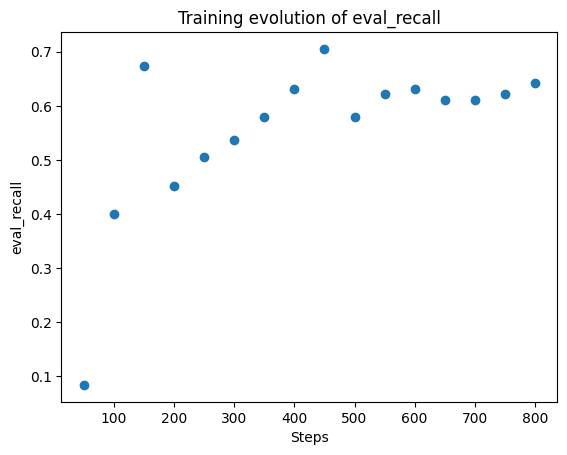

In [27]:
plot_metric_evolution(trainer_state, "eval_recall")

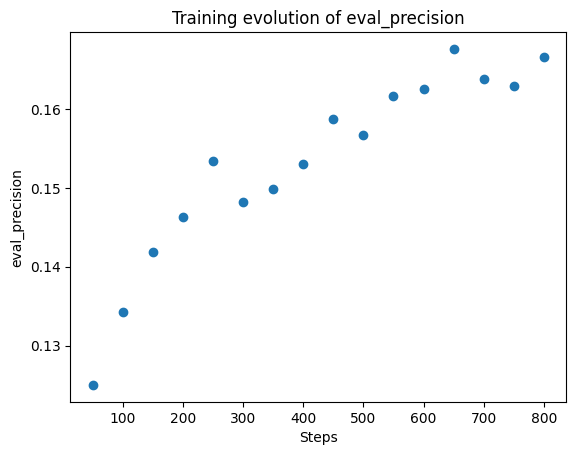

In [28]:
plot_metric_evolution(trainer_state, "eval_precision")

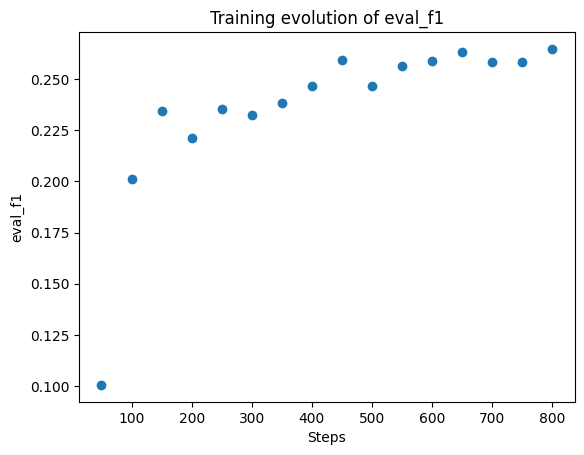

In [29]:
plot_metric_evolution(trainer_state, "eval_f1")

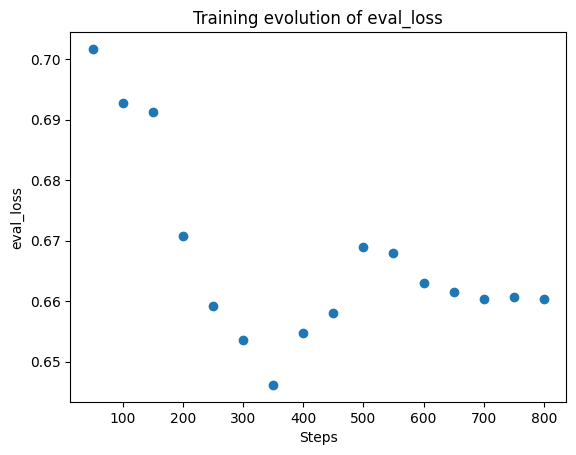

In [30]:
plot_metric_evolution(trainer_state, "eval_loss")

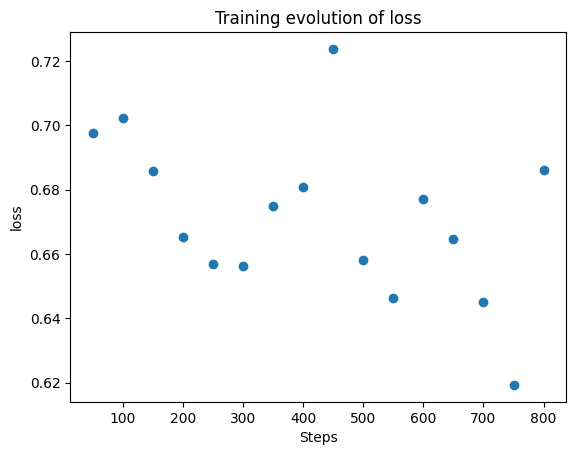

In [31]:
plot_metric_evolution(trainer_state, "loss")